<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

In [1]:
import pandas as pd 
from datetime import datetime,date
import datetime
import numpy as np
import xarray as xr
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import re

### Load Co-located ERA5 data (+ TOPAZ reanalysis)

In [2]:
era5_sfs60 = pd.read_csv('/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs_level2v3_60_ERA5.csv')
for i in range(np.max(np.shape(era5_sfs60))):
    era5_sfs60.loc[i, 'datetime'] = datetime.datetime.strptime(era5_sfs60.loc[i, 'datetime'], '%Y-%m-%d %H:%M:%S')

### Load MOSAiC data and filter to hourly data corresponding to the ERA5 data

In [3]:
# Run the first time
#mosasfs60met = xr.open_dataset("/lustre/storeB/users/maltem/nowwind/MOSAiC/mosseb.metcity.level2v3.10min.all.nc" 
#mosasfs60met_1h = mosasfs60met.resample(time="1H").interpolate("linear") 
#mosasfs60met_1h.to_netcdf("/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs60met.level2v3.1h.all.nc")

In [4]:
mosasfs60met_1h = xr.open_dataset("/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs60met.level2v3.1h.all.nc")

In [5]:
mosasfs60met_1h.down_short_hemisp[5000:6152] = np.nan
mosasfs60met_1h.down_short_hemisp[6921:7573] = np.nan
mosasfs60met_1h.up_short_hemisp[5000:6152] = np.nan
mosasfs60met_1h.up_short_hemisp[6921:7573] = np.nan

### Load sea ice Data from OSISAF and CryoSat-2-SMOS

In [6]:
path_sea_ice = '/lustre/storeB/users/justinec/master_internship/data/SEA_ICE/'
df_sea_ice = pd.read_csv(path_sea_ice+'Sea_ice_data_from_satellites.txt', sep='\t')

def format_date(x):
    return datetime.datetime.strptime(str(x), '%Y%m%d%H%M%S')

df_sea_ice['date'] = df_sea_ice['date'].map(format_date)
df_sea_ice = df_sea_ice.set_index('date')

### Harmonize time-axis and set time range

In [7]:
tstart=pd.Timestamp('2019-10-1'); tend=pd.Timestamp('2020-9-30')

mosasfs60met_1h = mosasfs60met_1h.sel(time=slice(tstart,tend))
df = era5_sfs60; df = df.set_index(['datetime']); df = df.loc[tstart:tend]; era5_sfs60  = df.reset_index() 

In [8]:
#df = mosasfs60met_1h.to_dataframe().reset_index(); df = df.set_index(['time']); df = df.loc[tstart:tend]; mosasfs60met_1h = df.reset_index() 

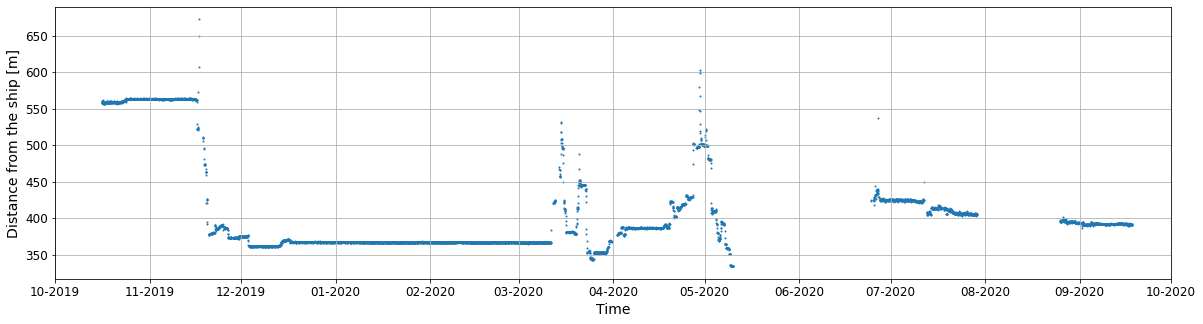

In [72]:
parameters = {'axes.labelsize':14, 'axes.titlesize':15, 'legend.fontsize':16, 'xtick.labelsize':12, 'ytick.labelsize':12, 
                  'legend.title_fontsize':14, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.scatter(mosasfs60met_1h.time,mosasfs60met_1h.ship_distance, s=1)
ax.set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator())
plt.xlabel('Time')
plt.grid()
plt.ylabel('Distance from the ship [m]')
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/'
plt.savefig(path_fig+'MetCity_distance.png',dpi=300, facecolor='white', transparent=False)

In [10]:
for i in range(len(era5_sfs60.istl)):
    if isinstance(era5_sfs60.istl[i], float) and np.isnan(era5_sfs60.istl[i]) :
        era5_sfs60.loc[i, 'istl'] = np.nan
    else:
        match = re.findall(r'\[(\d+\.?\d*)\]', era5_sfs60.loc[i, 'istl'])
        if match:
            era5_sfs60.loc[i, 'istl'] = float(match[0])

In [11]:
#outlier values in u MOSAiC
for i in range (0,len(mosasfs60met_1h.wspd_u_mean_10m)) :
    if mosasfs60met_1h.wspd_u_mean_10m[i] < -20 :
        mosasfs60met_1h.wspd_u_mean_10m[i] = np.nan

In [12]:
era5_sfs60_daily_mean = era5_sfs60.groupby(pd.Grouper(key='datetime', freq='D')).mean()

In [13]:
#mosasfs60met_1h_daily_mean = mosasfs60met_1h.groupby(pd.Grouper(key='time', freq='D'))

In [14]:
mosasfs60met_1h_daily_mean = mosasfs60met_1h.resample(time='D').mean()

In [15]:
#a=mosasfs60met_1h.groupby(pd.Grouper(key='time', freq='D')).agg({'down_short_hemisp': lambda x: x.mean(skipna=False)})

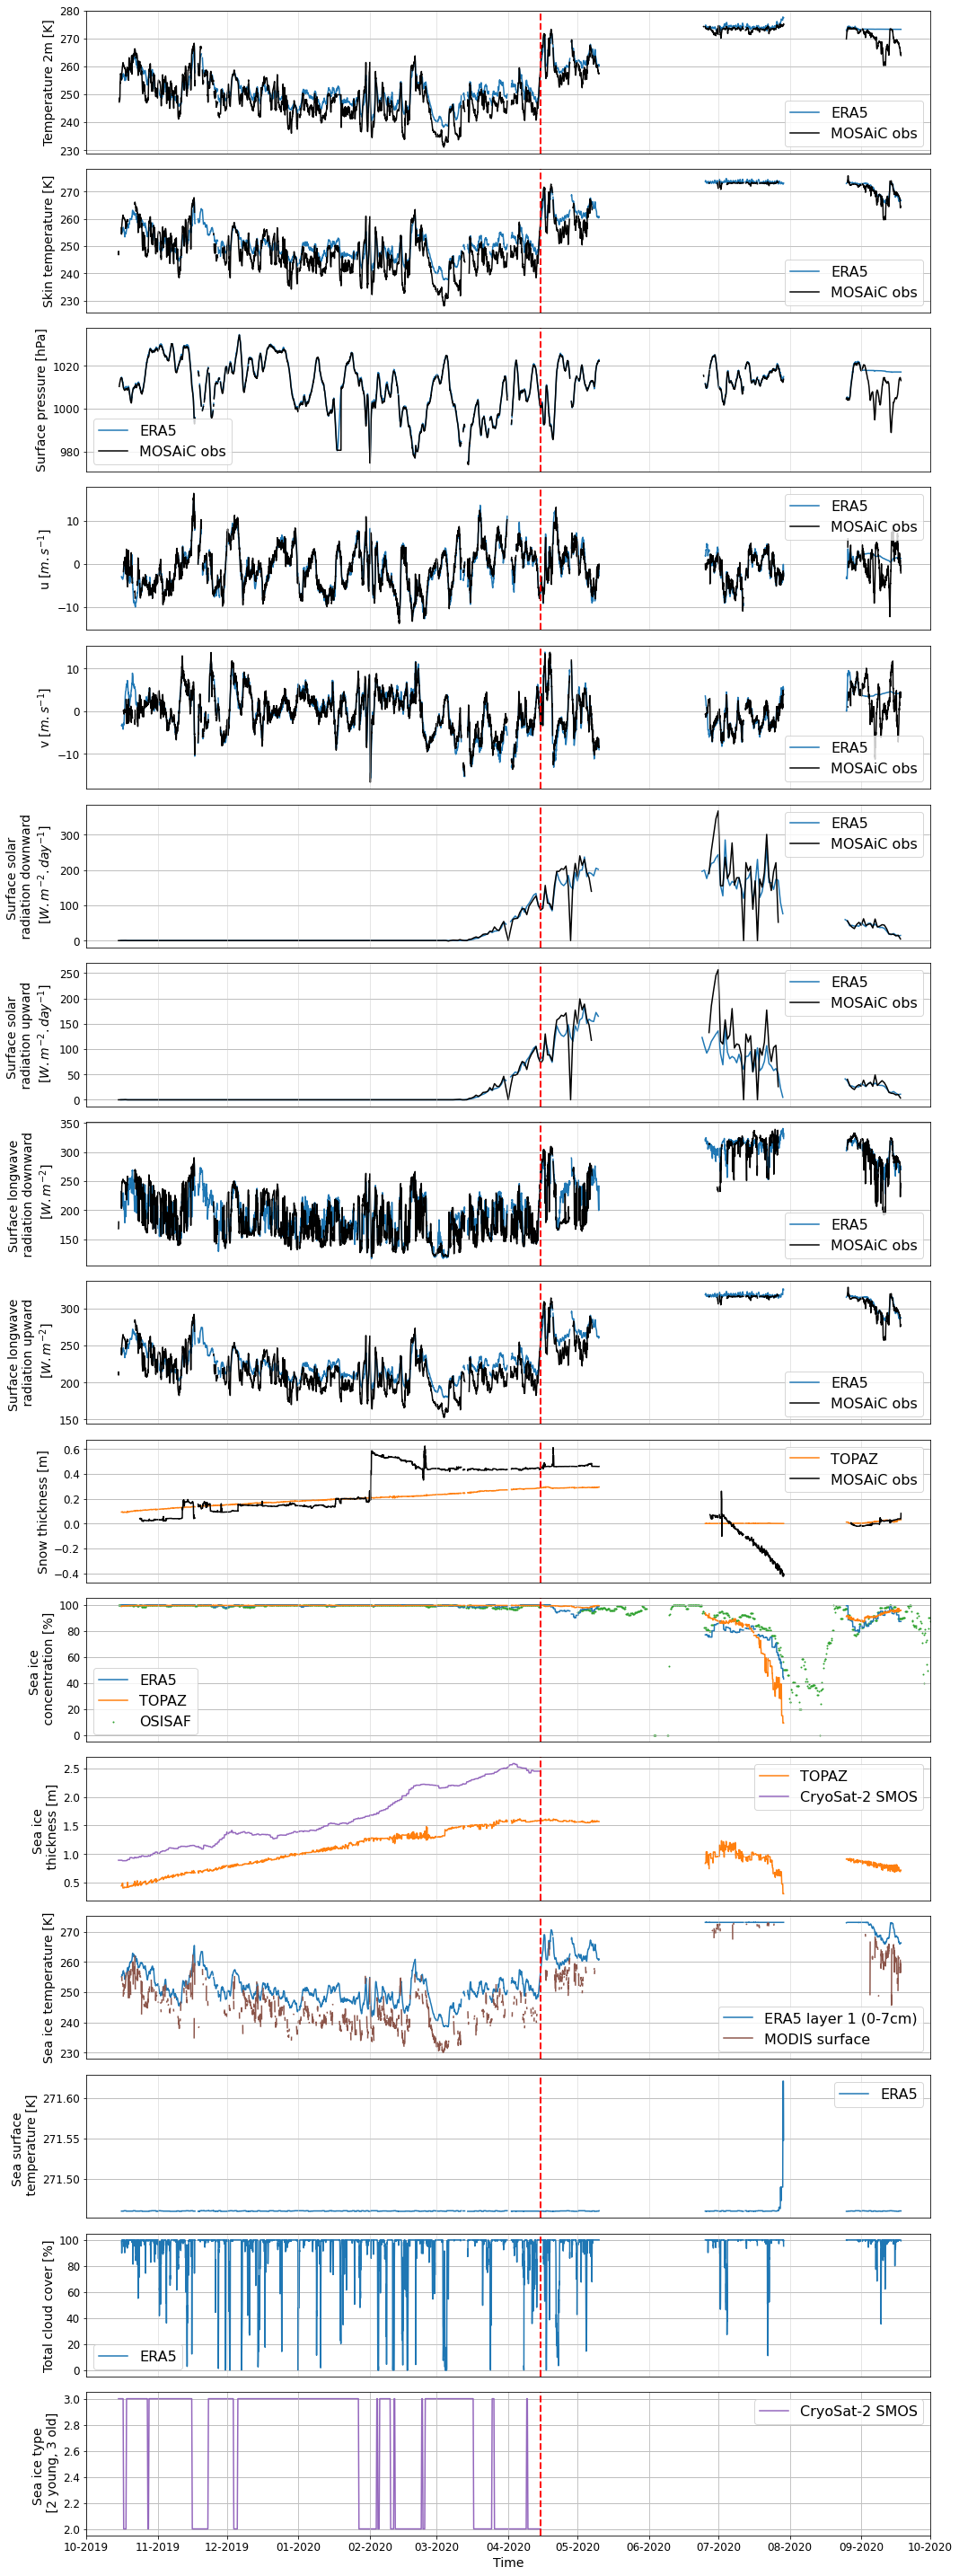

In [73]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
nb = 16
fig, axs = plt.subplots(nb,1,figsize=(15,40),gridspec_kw={'height_ratios': [1]*nb})

axs[0].plot(era5_sfs60.datetime, era5_sfs60.t2m,'-',label='ERA5',color='C0')
axs[0].plot(mosasfs60met_1h.time, mosasfs60met_1h.temp_2m+273.15,'-',label='MOSAiC obs',color='black')
axs[0].set_ylabel('Temperature 2m [K]')

axs[1].plot(era5_sfs60.datetime, era5_sfs60.skt,'-',label='ERA5',color='C0')
axs[1].plot(mosasfs60met_1h.time, mosasfs60met_1h.skin_temp_surface+273.15,'-',label='MOSAiC obs',color='black')
axs[1].set_ylabel('Skin temperature [K]')
#axs[1].yaxis.set_minor_locator(AutoMinorLocator(5))
#axs[1].yaxis.grid(which='major', color='#CCCCCC', linestyle='--')
#axs[1].yaxis.grid(which='minor', color='#CCCCCC', linestyle=':') 

axs[2].plot(era5_sfs60.datetime, era5_sfs60.sp/100,'-',label='ERA5',color='C0')
axs[2].plot(mosasfs60met_1h.time, mosasfs60met_1h.atmos_pressure_2m,'-',label='MOSAiC obs',color='black')
axs[2].set_ylabel('Surface pressure [hPa]')
#axs[2].yaxis.set_minor_locator(AutoMinorLocator(0.1))
#axs[2].yaxis.grid(which='major', color='#CCCCCC', linestyle='--')
#axs[2].yaxis.grid(which='minor', color='#CCCCCC', linestyle=':') 

axs[3].plot(era5_sfs60.datetime, era5_sfs60.u10m,'-',label='ERA5',color='C0')
axs[3].plot(mosasfs60met_1h.time, mosasfs60met_1h.wspd_u_mean_10m,'-',label='MOSAiC obs',color='black')
axs[3].set_ylabel('u [$m.s^{-1}$]')

axs[4].plot(era5_sfs60.datetime, era5_sfs60.v10m,'-',label='ERA5',color='C0')
axs[4].plot(mosasfs60met_1h.time, mosasfs60met_1h.wspd_v_mean_10m,'-',label='MOSAiC obs',color='black')
axs[4].set_ylabel('v [$m.s^{-1}$]')

axs[5].plot(era5_sfs60_daily_mean.index, era5_sfs60_daily_mean.ssrd/3600, '-',label='ERA5',color='C0')
axs[5].plot(mosasfs60met_1h_daily_mean.time, mosasfs60met_1h_daily_mean.down_short_hemisp, '-',label='MOSAiC obs',color='black')
axs[5].set_ylabel('Surface solar \n radiation downward \n [$W.m^{-2}.day^{-1}$]')

axs[6].plot(era5_sfs60_daily_mean.index, era5_sfs60_daily_mean.ssrd/3600-era5_sfs60_daily_mean.ssru/3600, '-',label='ERA5',color='C0')
axs[6].plot(mosasfs60met_1h_daily_mean.time, mosasfs60met_1h_daily_mean.up_short_hemisp, '-',label='MOSAiC obs',color='black')
axs[6].set_ylabel('Surface solar \n radiation upward \n [$W.m^{-2}.day^{-1}$]')

axs[7].plot(era5_sfs60.datetime, era5_sfs60.strd/3600,'-',label='ERA5',color='C0')
axs[7].plot(mosasfs60met_1h.time, mosasfs60met_1h.down_long_hemisp,'-',label='MOSAiC obs',color='black')
axs[7].set_ylabel('Surface longwave \n radiation downward \n [$W.m^{-2}$]')

axs[8].plot(era5_sfs60.datetime, era5_sfs60.strd/3600-era5_sfs60.stru/3600,'-',label='ERA5',color='C0')
axs[8].plot(mosasfs60met_1h.time, mosasfs60met_1h.up_long_hemisp,'-',label='MOSAiC obs',color='black')
axs[8].set_ylabel('Surface longwave \n radiation upward \n [$W.m^{-2}$]')

axs[9].plot(era5_sfs60.datetime, era5_sfs60.hsnow,'-',color='C1', label='TOPAZ')
axs[9].plot(mosasfs60met_1h.time, mosasfs60met_1h.snow_depth*1e-2,'-',label='MOSAiC obs',color='black')
axs[9].set_ylabel('Snow thickness [m]')

axs[10].plot(era5_sfs60.datetime, era5_sfs60.ci*100,'-',label='ERA5',color='C0')
axs[10].plot(era5_sfs60.datetime, era5_sfs60.fice*100,'-',color='C1', label='TOPAZ')
axs[10].scatter(df_sea_ice.index, df_sea_ice['sea_ice_concentration_osi[%]'], s=1, color='C2', label='OSISAF')
axs[10].set_ylabel('Sea ice \n concentration [%]')

axs[11].plot(era5_sfs60.datetime, era5_sfs60.hice,'-',color='C1', label='TOPAZ')
axs[11].plot(df_sea_ice.index, df_sea_ice['sea_ice_thickness[m]'], 'C4', label='CryoSat-2 SMOS')
axs[11].set_ylabel('Sea ice \n thickness [m]')

axs[12].plot(era5_sfs60.datetime, era5_sfs60.istl,'-',label='ERA5 layer 1 (0-7cm)',color='C0')
axs[12].plot(era5_sfs60.datetime, era5_sfs60.ist,'-',color='C5', label='MODIS surface')
axs[12].set_ylabel('Sea ice temperature [K]')

axs[13].plot(era5_sfs60.datetime, era5_sfs60.sstk,'-',label='ERA5',color='C0')
axs[13].set_ylabel('Sea surface \n temperature [K]')

axs[14].plot(era5_sfs60.datetime, era5_sfs60.tcc*100,'-',label='ERA5',color='C0')
axs[14].set_ylabel('Total cloud cover [%]')

axs[15].plot(df_sea_ice.index, df_sea_ice['sea_ice_type[2 young, 3 old]'], 'C4', label='CryoSat-2 SMOS')
axs[15].set_ylabel('Sea ice type \n [2 young, 3 old]')
axs[15].xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
axs[15].xaxis.set_major_locator(dates.MonthLocator())
axs[15].set_xlabel('Time')

months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,nb) :
    axs[i].axvline(datetime.date(2020, 4, 15), color='red', linestyle='--', linewidth='2')
    axs[i].legend()
    axs[i].set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
    axs[i].grid()
    for j in range(0,len(months_date)) :
        axs[i].axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
for i in range(0,nb-1) :
    axs[i].set_xticks([])

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/'
plt.savefig(path_fig+'MetCity.png',dpi=300, facecolor='white', transparent=False)

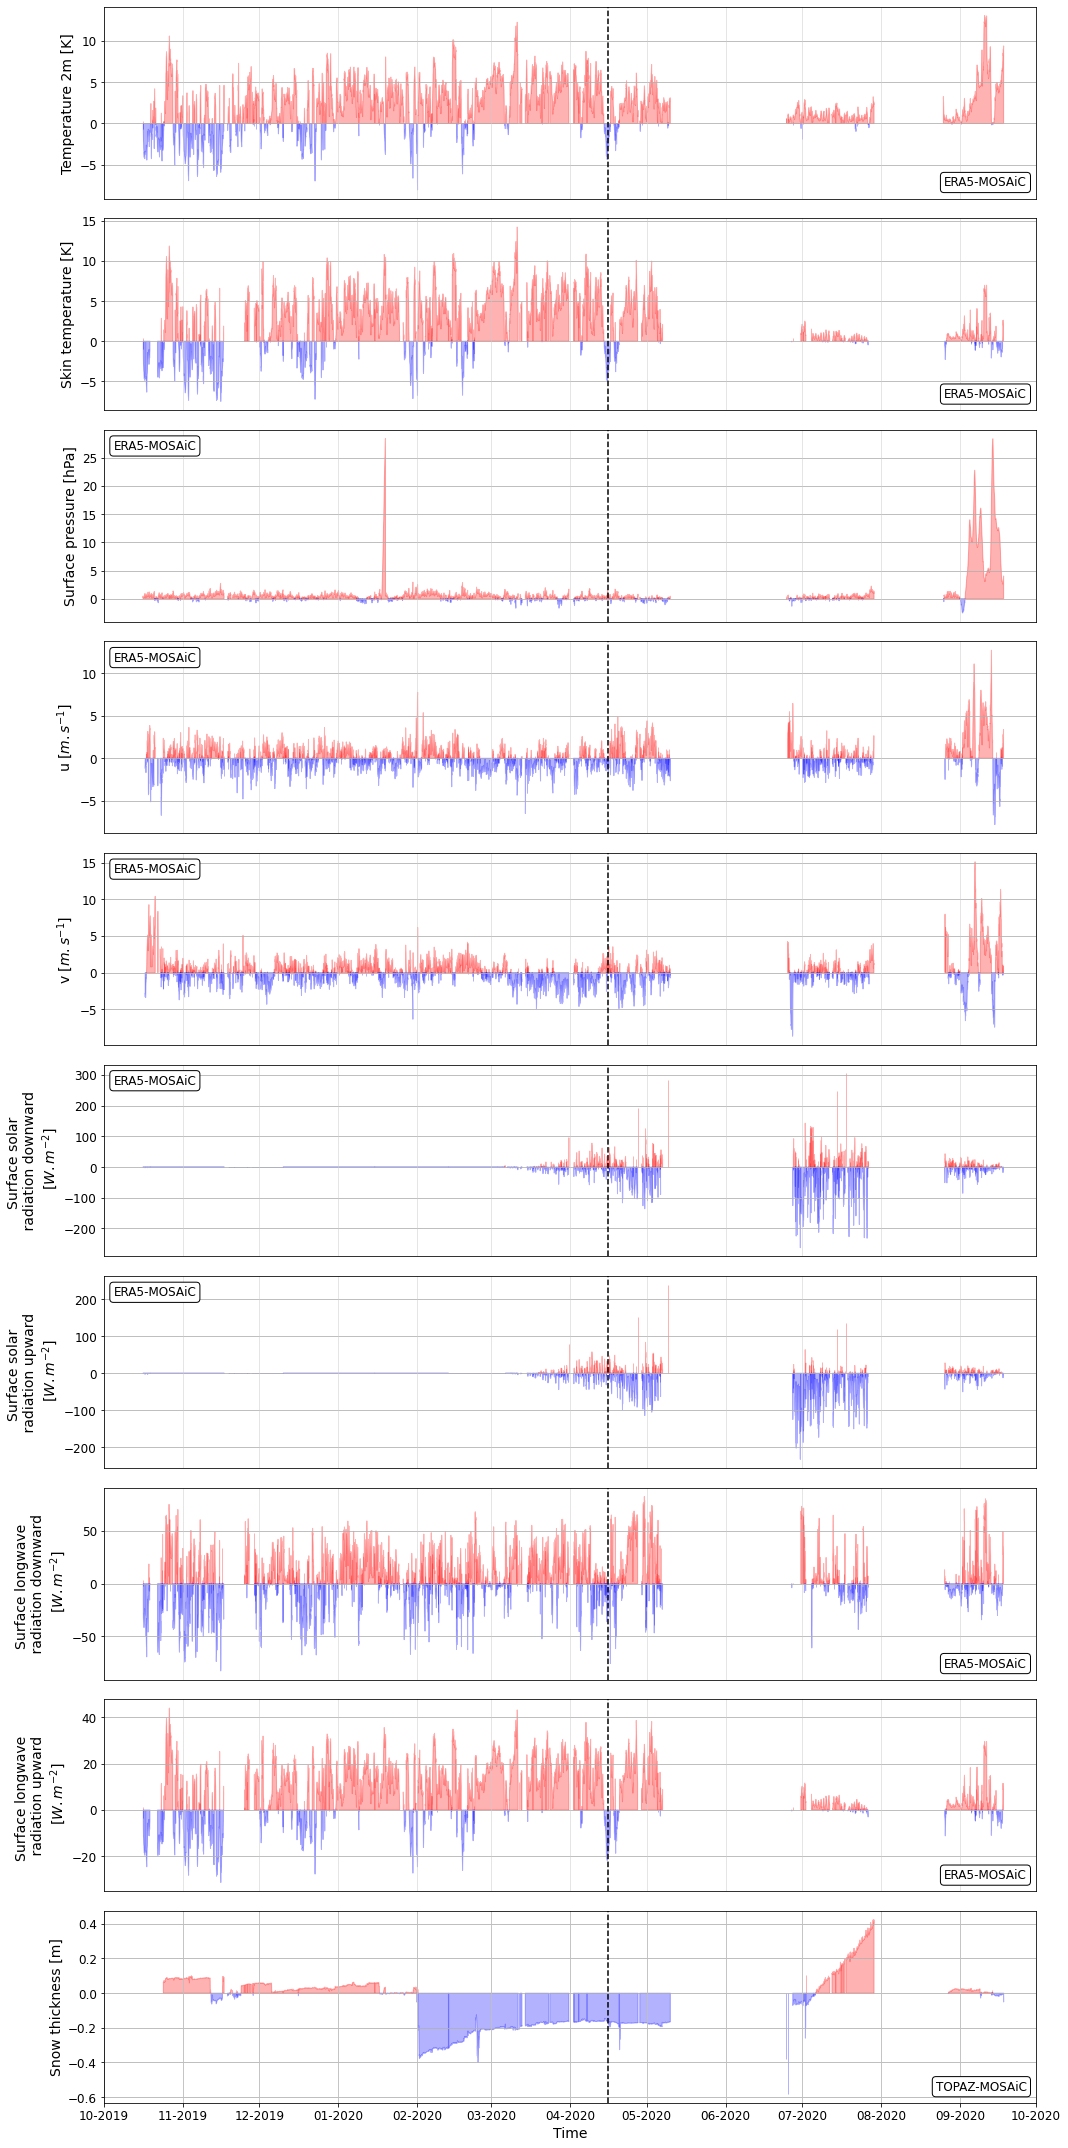

In [74]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
nb = 10
fig, axs = plt.subplots(nb,1,figsize=(15,30),gridspec_kw={'height_ratios': [1]*nb})
plt.rcParams['font.size'] = 12

#axs[0].plot(era5_sfs60.datetime, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15),'-',color='k', linewidth=1, alpha=0, label='ERA5-MOSAiC')
#axs[0].plot(era5_sfs60.datetime, np.where(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) > 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), np.nan), color='red')
#axs[0].plot(era5_sfs60.datetime, np.where(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) <= 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), np.nan), color='blue')
axs[0].fill_between(era5_sfs60.datetime, 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), where=(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) > 0), color='red', alpha=0.3)
axs[0].fill_between(era5_sfs60.datetime, 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), where=(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) <= 0), color='blue', alpha=0.3)
axs[0].set_ylabel('Temperature 2m [K]')
axs[0].text(0.99, 0.05, 'ERA5-MOSAiC', ha='right', va='bottom', transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[1].plot(era5_sfs60.datetime, era5_sfs60.skt-(mosasfs60met_1h.skin_temp_surface+273.15),'-',color='k', label='ERA5-MOSAiC')
axs[1].fill_between(era5_sfs60.datetime, 0, era5_sfs60.skt-(mosasfs60met_1h.skin_temp_surface+273.15), where=(era5_sfs60.skt-(mosasfs60met_1h.skin_temp_surface+273.15) > 0), color='red', alpha=0.3)
axs[1].fill_between(era5_sfs60.datetime, 0, era5_sfs60.skt-(mosasfs60met_1h.skin_temp_surface+273.15), where=(era5_sfs60.skt-(mosasfs60met_1h.skin_temp_surface+273.15) <= 0), color='blue', alpha=0.3)
axs[1].set_ylabel('Skin temperature [K]')
axs[1].text(0.99, 0.05, 'ERA5-MOSAiC', ha='right', va='bottom', transform=axs[1].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[2].plot(era5_sfs60.datetime, era5_sfs60.sp/100-mosasfs60met_1h.atmos_pressure_2m,'-',color='k', label='ERA5-MOSAiC')
axs[2].fill_between(era5_sfs60.datetime, 0, era5_sfs60.sp/100-mosasfs60met_1h.atmos_pressure_2m, where=(era5_sfs60.sp/100-mosasfs60met_1h.atmos_pressure_2m > 0), color='red', alpha=0.3)
axs[2].fill_between(era5_sfs60.datetime, 0, era5_sfs60.sp/100-mosasfs60met_1h.atmos_pressure_2m, where=(era5_sfs60.sp/100-mosasfs60met_1h.atmos_pressure_2m <= 0), color='blue', alpha=0.3)
axs[2].set_ylabel('Surface pressure [hPa]')
axs[2].text(0.01, 0.95, 'ERA5-MOSAiC', ha='left', va='top', transform=axs[2].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[3].plot(era5_sfs60.datetime, era5_sfs60.u10m-mosasfs60met_1h.wspd_u_mean_10m,'-',color='k', label='ERA5-MOSAiC')
axs[3].fill_between(era5_sfs60.datetime, 0, era5_sfs60.u10m-mosasfs60met_1h.wspd_u_mean_10m, where=(era5_sfs60.u10m-mosasfs60met_1h.wspd_u_mean_10m > 0), color='red', alpha=0.3)
axs[3].fill_between(era5_sfs60.datetime, 0, era5_sfs60.u10m-mosasfs60met_1h.wspd_u_mean_10m, where=(era5_sfs60.u10m-mosasfs60met_1h.wspd_u_mean_10m <= 0), color='blue', alpha=0.3)
axs[3].set_ylabel('u [$m.s^{-1}$]')
axs[3].text(0.01, 0.95, 'ERA5-MOSAiC', ha='left', va='top', transform=axs[3].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[4].plot(era5_sfs60.datetime, era5_sfs60.v10m-mosasfs60met_1h.wspd_v_mean_10m,'-',color='k', label='ERA5-MOSAiC')
axs[4].fill_between(era5_sfs60.datetime, 0, era5_sfs60.v10m-mosasfs60met_1h.wspd_v_mean_10m, where=(era5_sfs60.v10m-mosasfs60met_1h.wspd_v_mean_10m > 0), color='red', alpha=0.3)
axs[4].fill_between(era5_sfs60.datetime, 0, era5_sfs60.v10m-mosasfs60met_1h.wspd_v_mean_10m, where=(era5_sfs60.v10m-mosasfs60met_1h.wspd_v_mean_10m <= 0), color='blue', alpha=0.3)
axs[4].set_ylabel('v [$m.s^{-1}$]')
axs[4].text(0.01, 0.95, 'ERA5-MOSAiC', ha='left', va='top', transform=axs[4].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[5].plot(era5_sfs60.datetime, era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp,'-',color='k', label='ERA5-MOSAiC')
axs[5].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp, where=(era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp > 0), color='red', alpha=0.3)
axs[5].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp, where=(era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp <= 0), color='blue', alpha=0.3)
axs[5].set_ylabel('Surface solar \n radiation downward \n [$W.m^{-2}$]')
axs[5].text(0.01, 0.95, 'ERA5-MOSAiC', ha='left', va='top', transform=axs[5].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[6].plot(era5_sfs60.datetime, era5_sfs60.ssrd/3600-era5_sfs60.ssru/3600-mosasfs60met_1h.up_short_hemisp,'-',color='k', label='ERA5-MOSAiC')
axs[6].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-era5_sfs60.ssru/3600-mosasfs60met_1h.up_short_hemisp, where=(era5_sfs60.ssrd/3600-era5_sfs60.ssru/3600-mosasfs60met_1h.up_short_hemisp > 0), color='red', alpha=0.3)
axs[6].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-era5_sfs60.ssru/3600-mosasfs60met_1h.up_short_hemisp, where=(era5_sfs60.ssrd/3600-era5_sfs60.ssru/3600-mosasfs60met_1h.up_short_hemisp <= 0), color='blue', alpha=0.3)
axs[6].set_ylabel('Surface solar \n radiation upward \n [$W.m^{-2}$]')
axs[6].text(0.01, 0.95, 'ERA5-MOSAiC', ha='left', va='top', transform=axs[6].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[7].plot(era5_sfs60.datetime, era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp,'-',color='k', label='ERA5-MOSAiC')
axs[7].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp, where=(era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp > 0), color='red', alpha=0.3)
axs[7].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp, where=(era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp <= 0), color='blue', alpha=0.3)
axs[7].set_ylabel('Surface longwave \n radiation downward \n [$W.m^{-2}$]')
axs[7].text(0.99, 0.05, 'ERA5-MOSAiC', ha='right', va='bottom', transform=axs[7].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[8].plot(era5_sfs60.datetime, era5_sfs60.strd/3600-era5_sfs60.stru/3600-mosasfs60met_1h.up_long_hemisp,'-',color='k', label='ERA5-MOSAiC')
axs[8].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-era5_sfs60.stru/3600-mosasfs60met_1h.up_long_hemisp, where=(era5_sfs60.strd/3600-era5_sfs60.stru/3600-mosasfs60met_1h.up_long_hemisp > 0), color='red', alpha=0.3)
axs[8].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-era5_sfs60.stru/3600-mosasfs60met_1h.up_long_hemisp, where=(era5_sfs60.strd/3600-era5_sfs60.stru/3600-mosasfs60met_1h.up_long_hemisp <= 0), color='blue', alpha=0.3)
axs[8].set_ylabel('Surface longwave \n radiation upward \n [$W.m^{-2}$]')
axs[8].text(0.99, 0.05, 'ERA5-MOSAiC', ha='right', va='bottom', transform=axs[8].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#axs[9].plot(era5_sfs60.datetime, era5_sfs60.hsnow-(mosasfs60met_1h.snow_depth*1e-2),'-',color='k', label='TOPAZ-MOSAiC')
axs[9].fill_between(era5_sfs60.datetime, 0, era5_sfs60.hsnow-(mosasfs60met_1h.snow_depth*1e-2), where=(era5_sfs60.hsnow-(mosasfs60met_1h.snow_depth*1e-2) > 0), color='red', alpha=0.3)
axs[9].fill_between(era5_sfs60.datetime, 0, era5_sfs60.hsnow-(mosasfs60met_1h.snow_depth*1e-2), where=(era5_sfs60.hsnow-(mosasfs60met_1h.snow_depth*1e-2) <= 0), color='blue', alpha=0.3)
axs[9].set_ylabel('Snow thickness [m]')
axs[9].xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
axs[9].xaxis.set_major_locator(dates.MonthLocator())
axs[9].set_xlabel('Time')
axs[9].text(0.99, 0.05, 'TOPAZ-MOSAiC', ha='right', va='bottom', transform=axs[9].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    
months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,nb) :
    axs[i].axvline(datetime.date(2020, 4, 16), color='k', linestyle='--', linewidth='1.5')
    #axs[i].legend()
    axs[i].set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
    axs[i].grid()
    for j in range(0,len(months_date)) :
        axs[i].axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
for i in range(0,nb-1) :
    axs[i].set_xticks([])

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/'
plt.savefig(path_fig+'MetCity_errors.png',dpi=300, facecolor='white', transparent=False)